# Convolutional Neural Network

### The SVHN dataset (32-by-32 images)

---

The following notebook contains the source-code for my implementation of a simple convolutional neural network on the 32-by-32 images SVHN dataset.

In [12]:
import os
import time
import math
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0) # Set default figure size

print("Tensorflow version", tf.__version__

#### Loading the data

Let's load the greyscale images created in ``01-svhn-single-preprocessing.ipynb``

In [14]:
# Open the file as readonly
h5f = h5py.File('data/SVHN_single_greyscale.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_trainset'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_testset'][:]
y_test = h5f['y_test'][:]
X_val = h5f['X_valset'][:]
y_val = h5f['y_val'][:]

print('Training set', X_train.shape, y_train.shape)
print('Test set', X_test.shape, y_test.shape)
print('Validation set', X_val.shape, y_val.shape)

# Close this file
h5f.close()

('Training set', (598388, 32, 32, 1), (598388, 10))
('Test set', (26032, 32, 32, 1), (26032, 10))
('Validation set', (6000, 32, 32, 1), (6000, 10))


## Helper functions

Let's implement some helper functions to make our notebook easier to read and reduce code duplication.

### Helper function for plotting images

Here is a simple helper function that will help us plot ``nrows`` * ``ncols`` images with their true labels, and predicted labels - if passed to the function.

In [1]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    """ Plot nrows * ncols images from images and annotate the images
    """
    # Initialize the subplotgrid
    fig, axes = plt.subplots(nrows, ncols)
    
    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    # For every axes object in the grid
    for i, ax in zip(axes.flat, rs): 
        
        # Predictions are not passed
        if cls_pred is None:
            title = "True: {0}".format(np.argmax(cls_true[i]))
        
        # When predictions are passed, display labels + predictions
        else:
            title = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), cls_pred[i])  
            
        # Display the image
        ax.imshow(images[i,:,:,0], cmap='binary')
        
        # Annotate the image
        ax.set_title(title)
        
        # Do not overlay a grid
        ax.set_xticks([])
        ax.set_yticks([])
        
        
# Plot 2 rows with 9 images each from the training set
plot_images(X_train, 2, 9, y_train);

NameError: name 'X_train' is not defined

### Helper functions for creating new variables

Functions for creating new [``TensorFlow Variables``](https://www.tensorflow.org/how_tos/variables/) in the given shape and initializing them with random values. Note that the initialization is not actually done at this point, it is merely being defined in the TensorFlow graph.

In [16]:
def conv_weight_variable(layer_name, shape):
    """ Retrieve an existing variable with the given layer name 
    """
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer_conv2d())

def fc_weight_variable(layer_name, shape):
    """ Retrieve an existing variable with the given layer name
    """
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    """ Creates a new bias variable
    """
    return tf.Variable(tf.constant(1.0, shape=shape))

### Helper function for stacking CONV-RELU layers followed by an optional POOL layer

This function creates a new convolutional layer in the computational graph for TensorFlow. The most common form of a ConvNet architecture stacks a few CONV-RELU layers, follows them with POOL layers, and repeats this pattern until the image has been merged spatially to a small size. At some point it is common to transition to fully connected layers.

In other words, the most common ConvNet archiecture follows the pattern:

```INPUT > [[CONV -> RELU]*N -> POOL?]M -> [FC -> RELU]*K -> FC```

The following helper function simplifies the creation of this pattern

In [17]:
def conv_layer(input,               # The previous layer
                layer_name,         # Layer name
                num_input_channels, # Num. channels in prev. layer
                filter_size,        # Width and height of each filter
                num_filters,        # Number of filters
                pooling=True):      # Use 2x2 max-pooling

    # Shape of the filter-weights for the convolution
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new filters with the given shape
    weights = conv_weight_variable(layer_name, shape=shape)

    # Create new biases, one for each filter
    biases = bias_variable(length=num_filters)

    # Create the TensorFlow operation for convolution
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME') # with zero padding

    # Add the biases to the results of the convolution
    layer += biases
    
    # Rectified Linear Unit (RELU)
    layer = tf.nn.relu(layer)

    # Down-sample the image resolution?
    if pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Return the resulting layer and the filter-weights
    return layer, weights

### Helper function for reshaping the CONV layers to FC layers

A convolutional layer produces an output tensor with 4 dimensions. We will add fully-connected layers after the convolution layers, so we need to reduce the 4-dim tensor to 2-dim which can be used as input to the fully-connected layer. E.g., if the input layer has the shape (?, 8, 8, 32) the flattened layer will have the shape (?, 8 x 8 x 32) or (?, 2048).

In [18]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The number of features is: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    layer_flat = tf.reshape(layer, [-1, num_features])

    # Return the flattened layer and the number of features.
    return layer_flat, num_features

### Helper function for stacking FC-RELU layers

This function creates a new fully-connected layer in the computational graph for TensorFlow. Neurons in a fully connected layer have full connections to all activations in the previous layer, as seen in regular Neural Networks. Their activations can hence be computed with a matrix multiplication followed by a bias offset.

As mentioned in previous section most ConvNet architectures follows the following pattern:

```INPUT > [[CONV -> RELU]*N -> POOL?]M -> [FC -> RELU]*K -> FC```

The following helper function will simplify the process of stacking the last layers of the model.

In [19]:
def fc_layer(input,        # The previous layer
             layer_name    # The layer name
             num_inputs,   # Num. inputs from prev. layer
             num_outputs,  # Num. outputs
             relu=True):   # Use RELU?

    # Create new weights and biases.
    weights = fc_weight_variable(layer_name, shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer activation
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if relu:
        layer = tf.nn.relu(layer)

    return layer

## Tensorflow Model

The configuration of the Convolutional Neural Network and data dimensions are defined here for convenience, so you can easily find and change these numbers and re-run the Notebook.

Let's build our tensorflow graph step-by-step!

In [21]:
# We know that SVHN images have 32 pixels in each dimension
img_size = 32

# Greyscale images only have 1 color channel
num_channels = 1

# Number of classes, one class for each of 10 digits
num_classes = 10

# Convolutional Layer 1.
filter_size1 = 3          # Convolution filters are 5 x 5 pixels.
num_filters1 = 32         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 3          # Convolution filters are 5 x 5 pixels.
num_filters2 = 64         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

### Placeholder Variables

Placeholder variables serve as the input to the graph that we may change each time we execute the graph. First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix.

In [22]:
x = tf.placeholder(tf.float32, shape=(None, img_size, img_size, num_channels), name='x')

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable x.

In [23]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

y_true_cls = tf.argmax(y_true, dimension=1)

To reduce overfitting, we will apply dropout after the pooling layer. We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. 

In [3]:
keep_prob = tf.placeholder(tf.float32)

NameError: name 'tf' is not defined

### ConvNet Architecture

Let's implement the following ConvNet architecture based on the layer patterns proposed in the [``CS231n notes``](http://cs231n.github.io/convolutional-networks/#fc):

``` INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL] -> DROPOUT -> [FC -> RELU] -> FC ```

#### Convolutional Layer 1

Create the first convolutional layer. It takes x as input and creates num_filters1 different filters, each having width and height equal to filter_size1. 

In [24]:
conv_1, w_c1 = conv_layer(input=x,
                          layer_name="conv_1"
                          num_input_channels=num_channels,
                          filter_size=filter_size1,
                          num_filters=num_filters1, pooling=False)

conv_1

#### Convolutional Layer 2

Create the second convolutional layer, which takes as input the output from the first convolutional layer. The number of input channels corresponds to the number of filters in the first convolutional layer. Finally we wish to down-sample the image so it is half the size by using 2x2 max-pooling.

In [26]:
conv_2, w_c2 = conv_layer(input=conv_1,
                          layer_name="conv_2"
                          num_input_channels=num_filters1,
                          filter_size=filter_size2,
                          num_filters=num_filters2,
                          pooling=True)

# Apply dropout after the pooling operation
dropout = tf.nn.dropout(conv_2, keep_prob_1)

dropout

#### Flatten Layer

The convolutional layers output 4-dim tensors. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-dim tensors.

In [28]:
layer_flat, num_features = flatten_layer(dropout)

layer_flat

#### Fully-Connected Layer 1

Add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons or nodes in the fully-connected layer is fc_size. ReLU is used so we can learn non-linear relations.

In [30]:
fc_1 = fc_layer(input=layer_flat,
                layer_name="fc_1"
                num_inputs=num_features,
                num_outputs=fc_size,
                relu=True)

fc_1

#### Fully-Connected Layer 2

Add another fully-connected layer that outputs vectors of length 10 for determining which of the 10 classes the input image belongs to. Note that ReLU is not used in this layer.

In [32]:
fc_2 = fc_layer(input=fc_1,
                layer_name="fc_2"
                num_inputs=fc_size,
                num_outputs=num_classes,
                relu=False)

fc_2

#### Predicted Class

The second fully-connected layer estimates how likely it is that the input image belongs to each of the 10 classes. However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each element is limited between zero and one and the 10 elements sum to one. This is calculated using the so-called softmax function and the result is stored in y_pred.

In [34]:
y_pred = tf.nn.softmax(fc_2)

# The class-number is the index of the largest element.
y_pred_cls = tf.argmax(y_pred, dimension=1)

### Cost Function

To make the model better at classifying the input images, we must somehow change the variables for all the network layers. To do this we first need to know how well the model currently performs by comparing the predicted output of the model y_pred to the desired output y_true.

Cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the variables of the network layers.

In [35]:
# Calcualte the cross-entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc_2, labels=y_true)

# Take the average of the cross-entropy for all the image classifications.
cost = tf.reduce_mean(cross_entropy)

### Optimization Method

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the [``AdamOptimizer``](https://www.tensorflow.org/api_docs/python/train/optimizers#AdamOptimizer) which is an advanced form of Gradient Descent. In training deep networks, it is usually helpful to anneal the learning rate over time. There are three common types of implementing the learning rate decay. Here we will use **exponential decay** which has the mathematical form $\alpha = \alpha_0 / (1 + k_t)$ where $a_0, k$ are hyperparameters and $t$ is the iteration number. In practice Adam is currently recommended as the default algorithm to use, and often works slightly better than RMSProp. For more information on optimization see [CS231n - Learning](http://cs231n.github.io/neural-networks-3/#ada).

In [36]:
# Global step is required to compute the decayed learning rate
global_step = tf.Variable(0, trainable=False)

starter_learning_rate = 0.1

# Apply exponential decay to the learning rate
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 100000, 0.96, staircase=True)

# Construct a new Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost, global_step=global_step)

### Evaluation Metric

To evaluate the performance of our Convolutional Network we calculate the average accuracy across all samples

In [37]:
# Predicted class equals the true class of each image?
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

# Cast predictions to float and calculate the mean
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Execution Phase

### Create TensorFlow Session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [38]:
session = tf.Session()

The variables for weights and biases must be initialized before we start optimizing them.

In [39]:
session.run(tf.initialize_all_variables())

#### Generation of summaries

The FileWriter class provides a mechanism to create an event file in a given directory and add summaries and events to it. The class updates the file contents asynchronously. This allows a training program to call methods to add data to the file directly from the training loop, without slowing down training.

In [ ]:
LOG_DIR = 'logs'

# Create a summary for our loss and accuracy
tf.summary.scalar("loss", loss)
tf.summary.scalar("accuracy", accuracy)

# Merge all the summaries
merged = tf.summary.merge_all()

# Create a summary writer, add the 'graph' to the event file.
train_writer = tf.summary.FileWriter(LOG_DIR + '/svhn_single_1_train', session.graph)
test_writer = tf.summary.FileWriter(LOG_DIR + '/svhn_single_2_test')

# Write log
train_writer.add_summary(summary, total_iterations)
test_writer.add_summary(summary, total_iterations)

# Close the log files
train_writer.close()
test_writer.close()

### Saver

In order to save the variables of the neural network, we now create a so-called Saver-object which is used for storing and retrieving all the variables of the TensorFlow graph. The saved files are often called checkpoints because they may be written at regular intervals during optimization.
This is the directory used for saving and retrieving the data.

In [46]:
saver = tf.train.Saver()

save_dir = 'checkpoints/'

# Create directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
save_path = os.path.join(save_dir, 'svhn_single_greyscale')

#### Restoring a Previous Session

Re-load all the variables that were saved to file during previous optimization (if any).

In [ ]:
saver.restore(sess=session, save_path=save_path)

### Helper function for executing the learning process

There are 600,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer. Additionally we must select a keep probability for our dropout tensor. The value of p=0.5 is a reasonable default, but this can be tuned on validation data. 

Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well.

In [40]:
# Number of training samples in each iteration 
train_batch_size = 64

# With probability 1 / keep prob output the input element, otherwise 0
keep_prob = 0.5

In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.

In [42]:
total_iterations = 0

def optimize(num_iterations, display_step):
    
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations, total_iterations + num_iterations):

        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        
        x_batch = X_train[offset:(offset + batch_size), :, :, :]
        y_batch = y_train[offset:(offset + batch_size), :]
        
        # Put the batch into a dict with the proper names
        feed_dict_train = {x: x_batch, y_true: y_true_batch, keep_prob: keep_prob}

        # Run the optimizer using this batch of training data.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every display_step
        if i % display_step == 0:
            
            # Calculate the accuracy on the training-set.
            batch_acc = session.run(accuracy, feed_dict=feed_dict_train)
            print("Minibatch accuracy at step %d: %.4f" % (i, batch_acc))
            
            # Calculate the accuracy on the validation-set
            validation_acc = session.run(accuracy, {x: X_val, y_true: y_val, keep_prob: 1.})
            print("Validation accuracy: %.4f" % validation_acc)

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Difference between start and end-times.
    time_dif = time.time() - start_time
    
    # Calculate the accuracy on the test-set
    test_accuracy = session.run(accuracy, {x: X_test, y_true: y_test, keep_prob: 1.})
    
    print("Test accuracy: %.4f" % test_accuracy)
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

Let's run 10,000 iterations and see if our model works.

In [43]:
optimize(num_iterations=10000, display_step=500)

Minibatch accuracy at step 0: 0.1875
Validation accuracy: 0.1000
Minibatch accuracy at step 2500: 0.9062
Validation accuracy: 0.7202
Minibatch accuracy at step 5000: 0.9844
Validation accuracy: 0.7795
Minibatch accuracy at step 7500: 0.9219
Validation accuracy: 0.8203
Minibatch accuracy at step 10000: 0.9375
Validation accuracy: 0.8315
Minibatch accuracy at step 12500: 0.9219
Validation accuracy: 0.8412
Minibatch accuracy at step 15000: 0.9844
Validation accuracy: 0.8500
Minibatch accuracy at step 17500: 0.9531
Validation accuracy: 0.8532
Minibatch accuracy at step 20000: 0.9844
Validation accuracy: 0.8635
Minibatch accuracy at step 22500: 0.9531
Validation accuracy: 0.8648
Minibatch accuracy at step 25000: 0.9844
Validation accuracy: 0.8652
Minibatch accuracy at step 27500: 0.9688
Validation accuracy: 0.8642
Minibatch accuracy at step 30000: 0.9844
Validation accuracy: 0.8648
Minibatch accuracy at step 32500: 0.9219
Validation accuracy: 0.8752
Minibatch accuracy at step 35000: 0.9219


As we can see the permance slowly but surely increases, which is good! Let's run an additional 200,000 iterations and see how well our model is performing

In [ ]:
optimize(num_iterations=200000, display_step=10000)

 Let's save all variables of the TensorFlow graph to file.

In [48]:
saver.save(sess=session, save_path=save_path)

'checkpoints/svhn_single_greyscale'

### Model evaluation

Let's plot some of the mis-classified examples in our testset and a confusion matrix showing how well our model is able to predict the different digits.

In [49]:
# Generate predictions for the testset
test_pred = session.run(y_pred_cls, feed_dict={x: X_test, y_true:y_test})

Let's find some incorrectly classified examples and plot the true and predicted label values

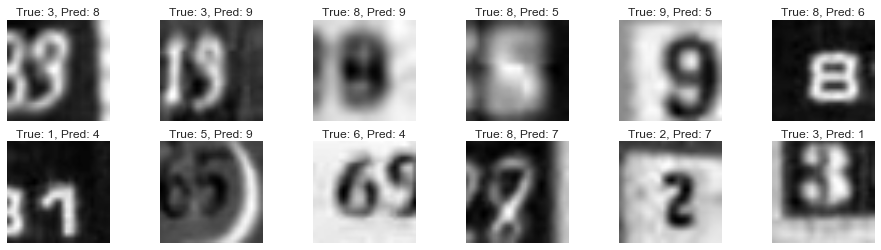

In [52]:
# Find the incorrectly classified examples
incorrect = test_pred != np.argmax(y_test, axis=1)

# Select the incorrectly classified examples
images = X_test[incorrect]
cls_true = y_test[incorrect]
cls_pred = test_pred[incorrect]

# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred);

... and some correctly classified examples.

In [ ]:
# Find the incorrectly classified examples
correct = np.invert(incorrect)

# Select the correctly classified examples
images = X_test[correct]
cls_true = y_test[correct]
cls_pred = test_pred[correct]

# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred);

We can also plot a [``confusion matrix``](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to show how well our model is able to predict the different class values

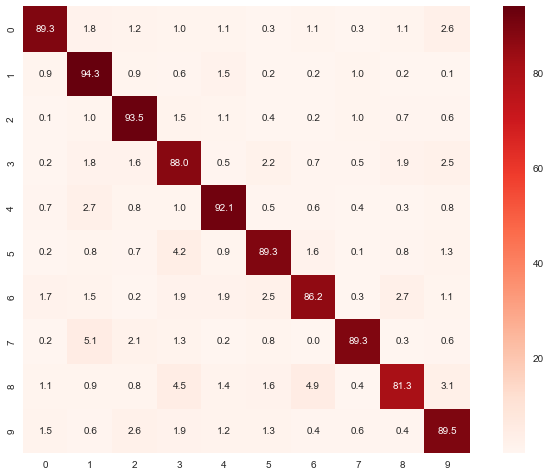

In [53]:
from sklearn.metrics import confusion_matrix

# Set the figure size
plt.figure(figsize=(12, 8))

# Calculate the confusion matrix
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=test_pred)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);